## Quora Question-pair classification

This project idea is taken from the kaggle competition about modeling whether a pair of questions on Quora is semantically same or not. For this problem, there are over 400,000 training examples. Each row consists of two numeric Id's for each question, two question texts, and a binary label that indicates to us whether the two questions are duplicate in meaning or not.
<br><br>
<div>
<p> Steps to build the model:
   <ul>
    <li>Exploratory Data Analysis to handle missing data and outliers</li>
    <li>question pair TF-IDF encodings </li>
    <li>basic feature engineering  </li>
    <li>model selection and evaluation</li>
    </ul>
</p>
</div>

In [ ]:
# import the important libraries/packages
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
%matplotlib inline
import nltk
import seaborn as sns
import gensim

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [ ]:
train_data = pd.read_csv('D:\Downloads\Springboard Python\quora-question-pair\\train.csv')

In [ ]:
test_data = pd.read_csv('D:\Downloads\Springboard Python\quora-question-pair\\test.csv')

## 1. EDA

### Train data analysis

**1.1 A few rows of the dataset**

In [ ]:
train_data.head()

**1.2 Columns of the data set**

In [ ]:
train_data.columns

**1.3 Size of the Data set**

In [ ]:
print("Size of the test data: ", test_data.shape)
print("Size of the train data: ", train_data.shape)

**1.4 Data type of each columns and Missing Data**

In [ ]:
train_data.info()

<div class ='span5 alert alert-info'> 
 <strong>  NOTE: There are 2 missing data in 'question2' column.</strong>
</div>

In [ ]:
# Drop The missing value and duplicate rows
train_df = train_data.dropna()
train_df = train_df.drop_duplicates()

# Data type and info after dropping the na values
train_df.info()

**1.5 Number of similar and different questoions:**

In [ ]:
train_df.groupby("is_duplicate")['id'].count()

In [ ]:
plt.figure(figsize=(8, 8))
plt.bar([0,1],train_df.groupby("is_duplicate")['id'].count(),color=[(1,0.2,0.2,0.8), ((0,0,1,0.8))])
plt.xticks([0,1])
plt.xlabel('Is Duplicate(yes=1, no=0)')
plt.ylabel('Number of question-pairs')
plt.title("Distribution of labels data ")
plt.show()

### question1 column character-length insights

**1.6 Number of characters in the  questions in question1 column**

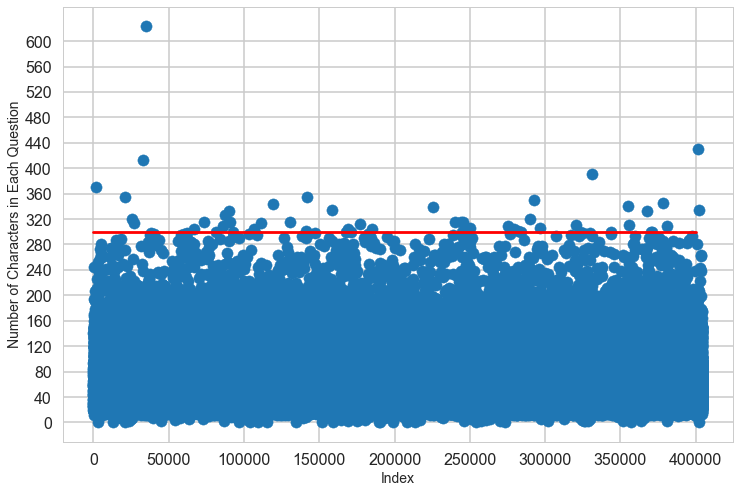

In [11]:
plt.figure(figsize=(12, 8))
plt.scatter(np.arange(len(train_df.question1)), train_df.question1.str.len())
plt.plot([-1,400000],[300,300], color='r')
plt.yticks(range(0,640,40))
plt.xlabel("Index", size=14)
plt.ylabel("Number of Characters in Each Question",size=14)
plt.show()

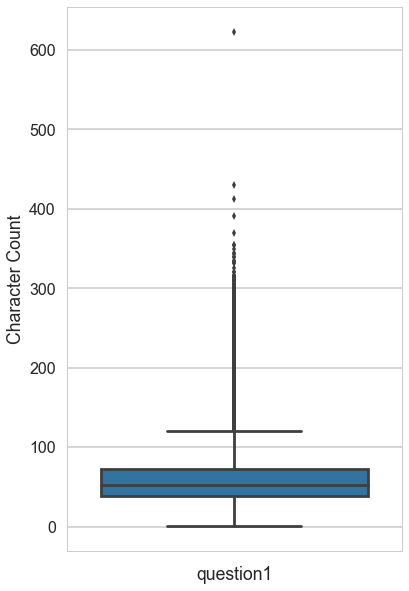

In [12]:
plt.figure(figsize=(6,10))
sns.set_style('whitegrid')
sns.boxplot(sorted(train_df.question1.str.len(),reverse=True), orient='v', )
plt.xlabel('question1')
plt.ylabel('Character Count')
plt.show()

### questionn2 column character-length insight

**1.7 Number of the characters in the questions in question2 columns**

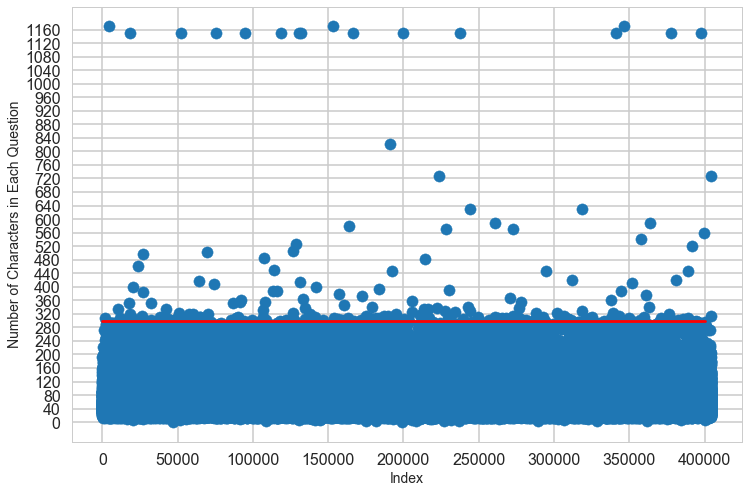

In [13]:
plt.figure(figsize=(12, 8))
plt.scatter(np.arange(len(train_df.question2)), train_df.question2.str.len())
plt.plot([-1,400000],[300,300], color='r')
plt.yticks(range(0,1200,40))
plt.xlabel("Index", size=14)
plt.ylabel("Number of Characters in Each Question",size=14)
plt.show()

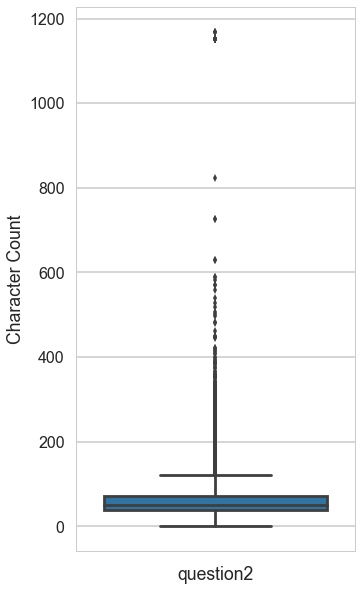

In [14]:
plt.figure(figsize=(5,10))
sns.boxplot(sorted(train_df.question2.str.len(),reverse=True), orient='v', )
plt.xlabel('question2')
plt.ylabel('Character Count')
plt.show()

### 1.8 Observations and comments:
<hr>
<div>
<ul>
<li> From the box plot it is clear that, the distributions of the question character-lengths are right skewed </li>
<li> More than 99% questions are below 280 character-lengths.</li>
<li> Median character-length for both question1 column is approximately 60, where for question2 column it is about 120</li>
</ul>
<hr>
</div>

### 1.9 Most Common words in the question-pairs 

In [15]:
train_data.question2.fillna('', inplace=True)
train_data.question1.fillna('', inplace=True)
text1 = " ".join(train_data['question1']).lower()
text2 = " ".join(train_data["question2"]).lower()
text1 = gensim.parsing.remove_stopwords(text1)
text2 = gensim.parsing.remove_stopwords(text2)
text1 = gensim.parsing.strip_punctuation2(text1)
text2 = gensim.parsing.strip_punctuation2(text2)
text1 = gensim.parsing.strip_short(text1, minsize=3)
text2 = gensim.parsing.strip_short(text2, minsize=3)
words1 = re.findall('\w+', text1)
words2 = re.findall('\w+', text2)

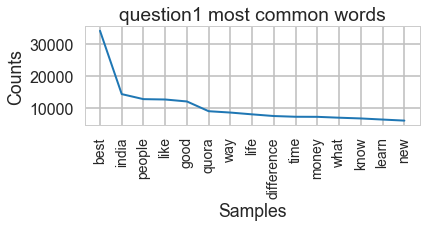

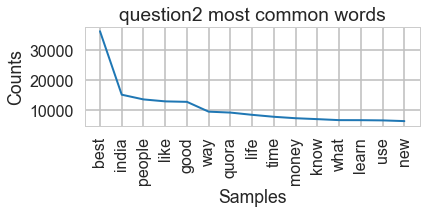

In [16]:
# Creating the word frequency distribution
freqdist1 = nltk.FreqDist(words1)
freqdist2 = nltk.FreqDist(words2)


# Plotting the word frequency distribution of question1
plt.subplot(2,1,2)
plt.xticks(fontsize =14)
plt.title('question1 most common words')
plt.xlabel('words')
freqdist1.plot(15)

plt.subplot(2,1,2)
plt.title('question2 most common words')
plt.xlabel('words')
freqdist2.plot(15)
plt.show()

## 2. Text Preprocessing and Feature Engineering

### 2.1 Text Processors 

All text column need to be combined row-wise before vectorizing the data. For a better result, noisy data such as word counts outliers, character count outliers,  foreign characters, punctuations need to be removed before tokenize and vectorize the text data. combined_Text will combine all the text data row-wise and preProcessText functino will perform the remaining text processing.

In [17]:
def combined_Text(df, to_combine = ['question1', 'question2']):
    """ converts all text in each row of data_frame to single vector """
    
    # Data frame with the text columns that are in the df
    text_data = df[to_combine]
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)


In [18]:
def preProcessText(text):
    """ This function takes a text or list of text as its input and returns a processed text.
        1. Change the string to lower case
        2. Remove non utf-8 characters
        3. Remove common stopwords 
        4. Remove all the punctuation2
        5. Remove multiple whitespaces
        6. Stem the text  """
    
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # Convert text to lower
    text = text.lower()
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    
    # Removing all the stopwords
    filtered_words = [word for word in text.split() if word not in stops]
        
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Strip single characters and numbers
    text = gensim.parsing.preprocessing.strip_short(text, minsize=2)
        
    # Stemming: gensim.parsing.PorterStem() or
    return gensim.parsing.preprocessing.stem_text(text)

### 2.2 Feature engineering 
The given features are the question text pairs. After the text processing, many words, alphanumeric characters, and other characters will be removed, and the remaining text will be converted to the lowercase. It may result in significant information loss. That is why, it is necesary to add extra features such as number of words in a question, numbers of character in the questions.

In [19]:
def preProcess_datframe(data):
    """ adds new features to the dataset e.g. character length and the number of words in each question."""
    data['char_len1'] = data.question1.str.len()
    data['char_len2'] = data.question2.str.len()
    data['wlen1'] = data.question1.str.split().str.len()
    data['wlen2'] = data.question2.apply( lambda x: len(x.split(' ')))
    data['question1'] = data.question1.apply( lambda x: preProcessText(x))
    data['question2'] = data.question2.apply( lambda x: preProcessText(x))
    return data

#### 2.3 preprocess and add featurs to the training data
- Remove the outliers from the dataset
- Add word count and character count features
- Seperate the features and the label to build the a model 

In [20]:

train_df = train_data[(train_data.question1.str.len()<360)]
train_df = train_df[(train_df.question2.str.len()<600)]
X = preProcess_datframe(train_df[['question1', 'question2']].dropna())
y = train_df['is_duplicate']

**2.1 Seperate a hold-out dataset to test the model**

In [158]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

## 3. Training Models

**3.1 Create a pipeline**

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

get_text_data = FunctionTransformer(combined_Text, validate=False)
get_num_data = FunctionTransformer(lambda x:x[X.columns.tolist()[2:]], validate=False)

pl = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer())
                ]))
             ])
     
    ),('clf', MultinomialNB())])


In [171]:
# fit the pipelined model to the train data
pl.fit(X_train, y_train)
y_pred_proba = pl.predict_proba(X_test)

In [175]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_proba)

0.53625889749277955

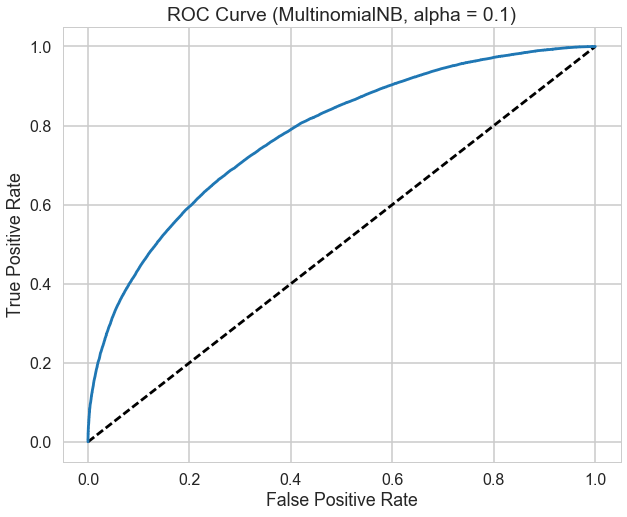

In [176]:
from sklearn.metrics import roc_curve
# Generate ROC curve values: fpr, tpr, thresholds
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_proba[:,1])

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (MultinomialNB, alpha = 0.1)')
plt.show()

## 4. Evaluation on the test data set

In [26]:
# find the index of the valid question pairs
valid_ids =[type(x)==int for x in test_data.test_id]

In [27]:
# remove all the invalid question pairs from the test dataset
test_df = test_data[valid_ids].drop_duplicates()

In [ ]:
# add the extra features to the dataset
test_X = preProcess_datframe(test_df[['question1', 'question2']].fillna(" "))

In [ ]:
y_pred_proba_test = pl.predict_proba(test_X)

In [ ]:
submission_file = pd.read_csv('sample_submission.csv')
submission_file['is_duplicate'] = y_pred_proba_test[:,1]
submission_file.head()

In [ ]:
submission_file.to_csv('submission.csv', index=False)

<div class ='span5 alert alert-info'> 
<strong>Kaggle Competition Score</strong>
<ul>
<li>Public Score: 0.43864</li>
<li>Private Score: 0.44003</li>
</ul>
</div>

## 5.  Model Refining

**5.1 Find the best min_df for tf-idf vectorizer**

In [177]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

In [178]:
parameters = {'clf__alpha': [0.001, 0.01, 0.1]}
searcher = GridSearchCV(pl, parameters, cv=5, error_score=log_loss)

In [179]:
searcher.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=<function log_loss at 0x000001A3762B3D90>,
       estimator=Pipeline(memory=None,
     steps=[('uninon', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001A3640957B8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y...    transformer_weights=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__alpha': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [196]:
# best value for alphha
searcher.best_params_

{'clf__alpha': 0.1}


In [189]:
y_searcher = searcher.predict_proba(X_test)
print("Log loss score with alpha=0.01: {}".format(log_loss(y_test, y_searcher)))

Log loss score with alpha=0.01: 0.5391205746552733


### 5.2 Prediction Probabilities with the Test Dataset with the best alpha value

In [162]:
# predict probability with the improved estimators
test_y_improved = searcher.predict_proba(test_X)

### 5.3 Further improvement using n-gram and best parameter for Tf-idf vectorizer**

In [190]:
# find the best min_df value for the the Tfidfvectorizer
logloss_count = None
logloss_min = 10
min_df_count = None
for min_df in [1, 10, 20, 40]:
    pl_n_gram = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df=min_df, ngram_range=(1,2)))
                ]))
             ])
     
    ),('clf', MultinomialNB(alpha=0.1))])
    pl_n_gram.fit(X_train, y_train)
    y_n_gram = pl_n_gram.predict_proba(X_test) 
    logloss_count = log_loss(y_test, y_n_gram)
    if logloss_count < logloss_min:
        logloss_min = logloss_count
        min_df_count = min_df
        
print('Best min_df : {}'.format(min_df_count))

Best min_df : 1


In [191]:
# best Logloss score with all improved parameters 
print("Improved log_loss score : {}".format(logloss_min))

Improved log_loss score : 0.47924195618324966


### 5.4     Evaluation on test data set using the updated min_df, alpha, and n_gram

In [192]:
# Improved pipeline with min_df, alpha, and n_gram
pl_n_gram = Pipeline([
    ('uninon', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', get_num_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', TfidfVectorizer(min_df = 1, ngram_range=(1,2)))
                ]))
             ])
     
    ),('clf', MultinomialNB(alpha=0.1))])

In [193]:
# fit the pipelined model to the train data
pl_n_gram.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('uninon', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001A3640957B8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y...    transformer_weights=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [ ]:
# Prediction probability of the Testing dataset with the improved parameters 
test_y_n_gram = pl_n_gram.predict_proba(test_X)

In [ ]:
submission_file['is_duplicate'] = y_pred_proba_test[:,1]
submission_file.head()

In [ ]:
submission_file.to_csv('submission_n_gram.csv', index=False)

### 7. Recommendations

This model is built on the basic Naive Base classifier with very minimal parameter tuning due to the time constraints. Further parameter tuning with cross validation of different folding of the training data set would definitely improve the model. Besides, this model only uses 6 features such as the text of the quetions, word counts, and character counts. It also ignores the case of the characters, foreign characters, and special characters, which may casuse a potential information loss. 
For future experiment some recommended steps are following: 
- Add special characters count, word share ratio, capitalization count as features
- Use word lemmatization insted of stemming them
- Deep learning implementation such word2vec, doc2vec, neural networks, LSTM
- Implement more sophisticated classifier such svm or ensemble classifiers